## Imports 

In [9]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
import glob
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate
import seaborn as sns
import pyarrow 

## Read data and train-test-split

In [2]:
# Read in parquet files and drop NAs 
df_selected = pd.read_parquet('../data/events_with_hit_features_[cut_off_time=0.5].parquet').dropna()

# Filter for muons only for the training set
df_muons = df_selected.query('`class`== "muon"')

# Train test split (muon data)
train_df, test_df_muon = train_test_split(df_muons, random_state=42)

# Append pion data to the test set 
test_df = pd.concat([test_df_muon, df_selected.query('`class`== "pion"')])

# Define X and y
X_train = train_df.iloc[:, 1:19]
y_train = train_df['ring_radius_cal']
X_test = test_df.iloc[:, 1:19]
y_test = test_df['ring_radius_cal']



## Train the model

In [3]:
# Define the model
xgb_reg = xgb.XGBRegressor()

# Fit the model 
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Cross validation 

In [11]:
# 5-fold cross validation on the training data
xgb_cv = cross_validate(xgb_reg, X_train, y_train, cv=5, return_train_score=True, scoring='r2')

# Displays the result 
pd.DataFrame(xgb_cv)

,fit_time,score_time,test_score,train_score
0,53.381856,0.106198,0.941561,0.962804
1,55.179456,0.093613,0.945178,0.962797
2,54.102978,0.112757,0.944914,0.962592
3,54.429839,0.096238,0.943565,0.962894
4,57.606197,0.101200,0.944547,0.962749


## Feature importance

In [13]:
# Display feature importance of the fitted model
pd.DataFrame({'features': xgb_reg.feature_names_in_, 'importance': xgb_reg.feature_importances_}).sort_values(by='importance', ascending=False)

,features,importance
10,hit_distance_median,0.867772
13,hit_distance_rms,0.040512
12,hit_distance_q75,0.020850
11,hit_distance_q25,0.013648
5,y_aligned_max,0.009103
2,x_aligned_max,0.008282
1,x_aligned_min,0.008224
15,hull_diameter,0.004398
8,hit_distance_max,0.003712
7,hit_distance_min,0.003470


## Compute the residuals

Text(0, 0.5, 'Residuals')

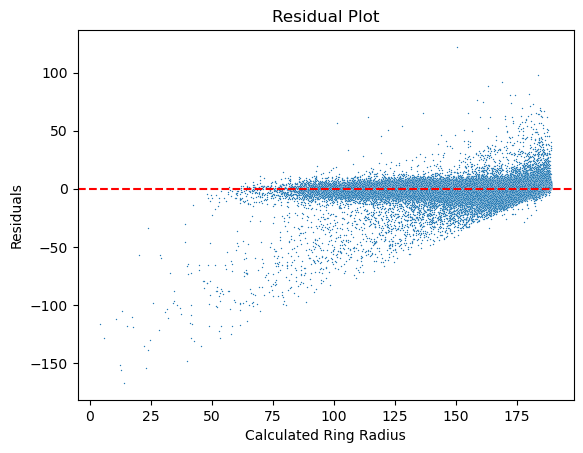

In [14]:
# Predict on the test set 
ypred = xgb_reg.predict(X_test)
pred_df = pd.DataFrame(ypred, y_test).reset_index()
pred_df.columns=['theoretical_radius', 'predicted_radius']

# Calculate the residual by subtracting the predicted radius from the theoretical radius 
pred_df['residual'] = pred_df['theoretical_radius'] - pred_df['predicted_radius']

# Plot the residuals vs. the theoretical radius 
sns.scatterplot(data=pred_df, x='theoretical_radius', y='residual', s=1)

plt.axhline(y=0, color='red', linestyle='--')

plt.title('Residual Plot')
plt.xlabel('Calculated Ring Radius')
plt.ylabel('Residuals')

In [ ]:
# Include track momentum in the prediction dataframe
pred_df['momentum'] = test_df.reset_index()['track_momentum']

## Comparison with SOTA using the entire dataset 

/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_68161/1327972730.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_comp['radius_pred'] = xgb_reg.predict(df_selected.iloc[:, 1:19])
/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_68161/1327972730.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_comp['res_model'] = res_comp['ring_radius_cal'] - res_comp['radius_pred']
/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_68161/1327972730.py:12: SettingWithCopyWarning: 
A

Text(0.5, 0.98, 'Residual vs. Predicted Ring Radius Comparison Between XGBRegressor and SOTA')

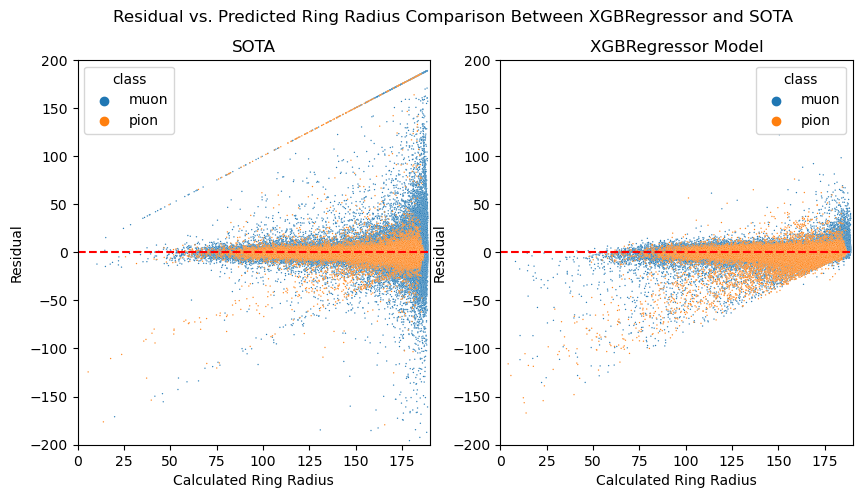

In [24]:
# Create a dataframe that contains both the predicted ring radii and the radii from SOTA 
# Note how the entire dataset is used for this comparison purpose 
res_comp = df_selected[['ring_radius_cal', 'ring_radius']]

# predict on the entire dataset using the fitted model
res_comp['radius_pred'] = xgb_reg.predict(df_selected.iloc[:, 1:19])

# Calculate the residuals for the model's predictions 
res_comp['res_model'] = res_comp['ring_radius_cal'] - res_comp['radius_pred']

# Calculate the residuals for the SOTA 
res_comp['res_sota'] = res_comp['ring_radius_cal'] - res_comp['ring_radius']

# Reset index
res_comp = res_comp.reset_index()

# Include momentum and class from the original dataset for plotting purpose 
res_comp[['momentum', 'class']] = df_selected.reset_index()[['track_momentum', 'class']]

# Plot the residual vs. the predicted ring radius for both our model and SOTA 
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(data=res_comp, x='ring_radius_cal', y='res_sota', s=1, hue='class', ax=axes[0])
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title('SOTA')
axes[0].set(ylim=(-200, 200))
axes[0].set(xlim=(0, 190))
axes[0].set_xlabel('Calculated Ring Radius')
axes[0].set_ylabel('Residual')

sns.scatterplot(data=res_comp, x='ring_radius_cal', y='res_model', s=1, hue='class', ax=axes[1])
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_title('XGBRegressor Model')
axes[1].set(ylim=(-200, 200))
axes[1].set(xlim=(0, 190))
axes[1].set_xlabel('Calculated Ring Radius')
axes[1].set_ylabel('Residual')

plt.suptitle('Residual vs. Predicted Ring Radius Comparison Between XGBRegressor and SOTA')

## Plot showing residual and `max_cal_diff` 
- `max_cal_diff` is calculated by subracting the maximum value of `ring_radius_cal` from `ring_radius_cal` 

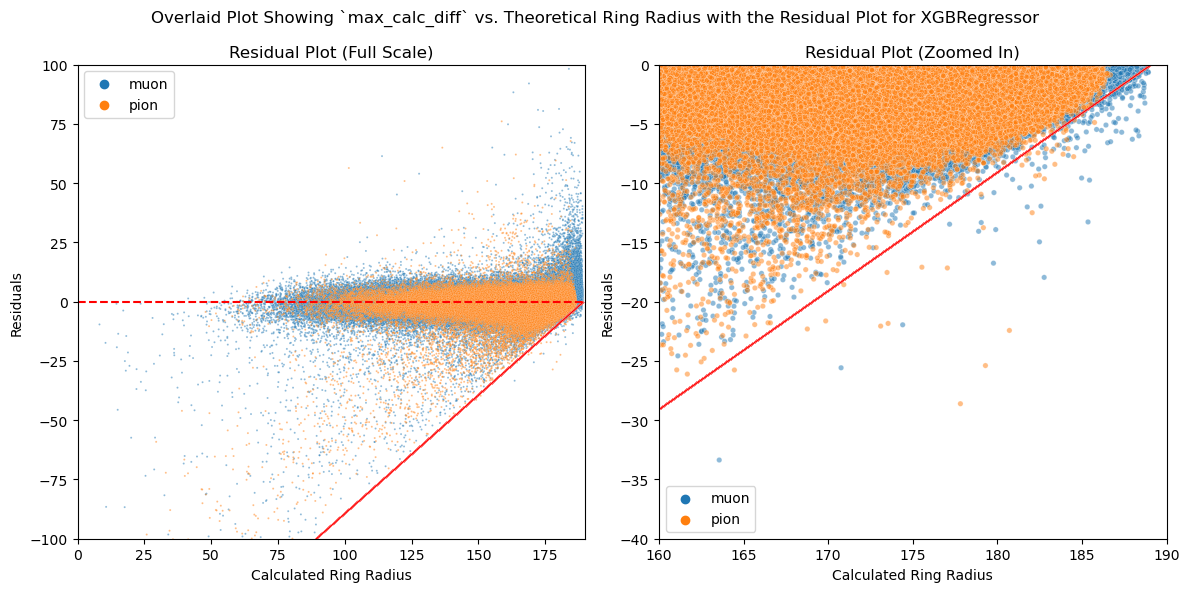

In [27]:
# Calculate the difference between theoretical ring radius and its maximum value for each example 
res_comp['max_calc_diff'] = res_comp['ring_radius_cal'] - res_comp['ring_radius_cal'].max()

# Overlay the plot showing `max_calc_diff` vs. theoretical ring radius with the residual plot 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left plot - Full scale
sns.scatterplot(data=res_comp, x='ring_radius_cal', y='res_model', s=2, alpha=0.5, hue='class', ax=axes[0])
g = sns.scatterplot(data=res_comp, x='ring_radius_cal', y='max_calc_diff', s=1, color='red', alpha=0.2, ax=axes[0])

axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlim(0, 190)
axes[0].set_ylim(-100, 100)
axes[0].set_title('Residual Plot (Full Scale)')
axes[0].set_xlabel('Calculated Ring Radius')
axes[0].set_ylabel('Residuals')

# Right plot - Zoomed in
sns.scatterplot(data=res_comp, x='ring_radius_cal', y='res_model', s=15, alpha=0.5, hue='class', ax=axes[1])
g = sns.scatterplot(data=res_comp, x='ring_radius_cal', y='max_calc_diff', s=1, color='red', alpha=0.2, ax=axes[1])

axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlim(160, 190)
axes[1].set_ylim(-40, 0)
axes[1].set_title('Residual Plot (Zoomed In)')
axes[1].set_xlabel('Calculated Ring Radius')
axes[1].set_ylabel('Residuals')

plt.suptitle('Overlaid Plot Showing `max_calc_diff` vs. Theoretical Ring Radius with the Residual Plot for XGBRegressor')
plt.tight_layout()


## Plotting predicted and theoretical radius vs. track momentum

/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_68161/2499806619.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [100]
/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_68161/2499806619.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/Jialing/opt/miniconda3/envs/591/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/Jialing/opt/miniconda3/envs/591/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


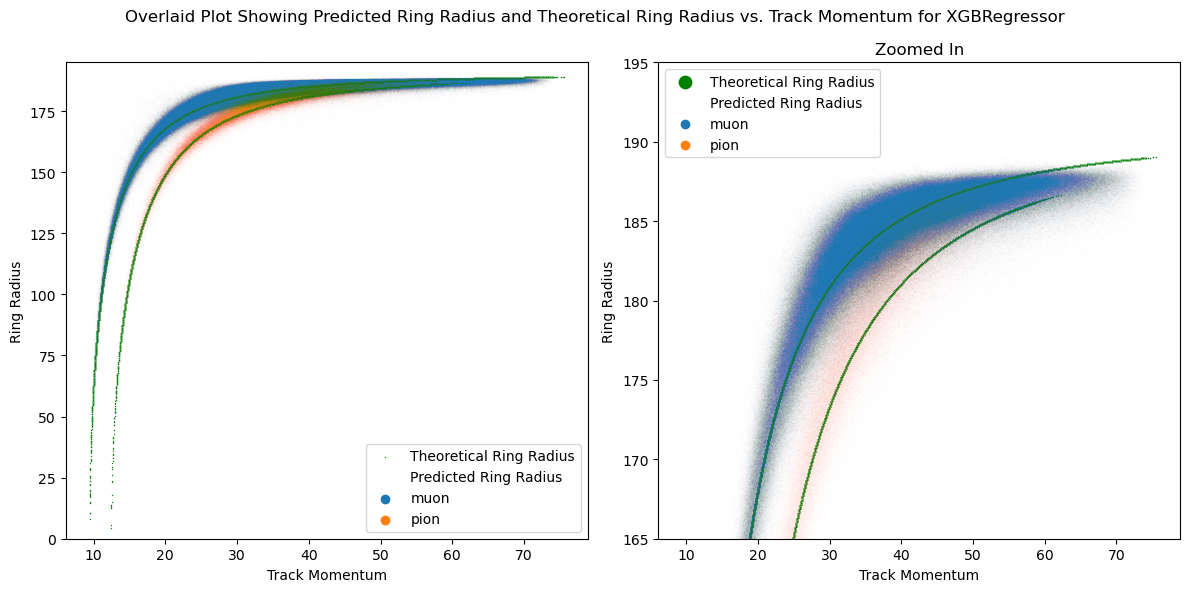

In [35]:
# Show the overlaid plot of predicted ring radius vs. track momentum and plot of theoretical ring radius vs. track momentum

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left plot - Full scale
sns.scatterplot(data=res_comp, x='momentum', y='ring_radius_cal', color='green', s=1, label='Theoretical Ring Radius', ax=axes[0])
g = sns.scatterplot(data=res_comp, x='momentum', y='radius_pred', s=1, hue='class', alpha=0.007, label='Predicted Ring Radius', ax=axes[0])
axes[0].set_xlabel('Track Momentum')
axes[0].set_ylabel('Ring Radius')
axes[0].set_ylim(0, 195)
axes[0].legend()

# Right plot - Zoomed in
sns.scatterplot(data=res_comp, x='momentum', y='ring_radius_cal', color='green', s=1, label='Theoretical Ring Radius', ax=axes[1])
g = sns.scatterplot(data=res_comp, x='momentum', y='radius_pred', s=1, hue='class', alpha=0.007, label='Predicted Ring Radius', ax=axes[1])
axes[1].set_xlabel('Track Momentum')
axes[1].set_ylabel('Ring Radius')
axes[1].set_ylim(165, 195)
axes[1].legend()
axes[1].set_title('Zoomed In')

plt.suptitle('Overlaid Plot Showing Predicted Ring Radius and Theoretical Ring Radius vs. Track Momentum for XGBRegressor')

legend = plt.legend()
legend.legendHandles[0]._sizes = [100]

plt.tight_layout()


## Plot predicted radius vs. calculated ring radius for XGBRegressor

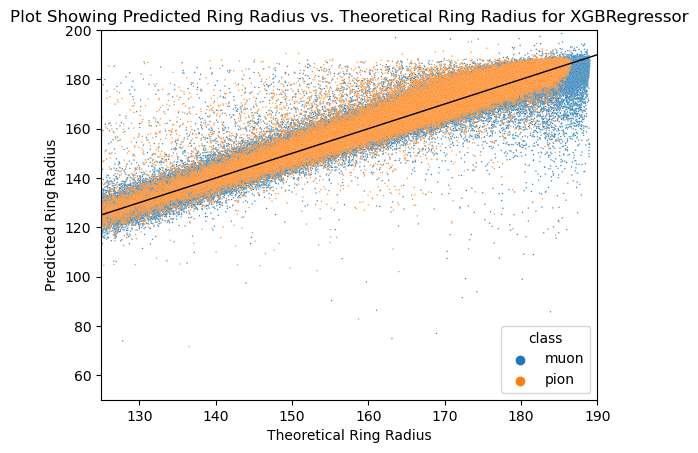

In [37]:
# Plot predicted ring radius vs. theoretical ring radius 

g = sns.scatterplot(data = res_comp, x = 'ring_radius_cal', y = 'radius_pred', hue='class', s=1)
g.set_xlim(125, 190)
g.set_ylim(50, 200)
g.set_xlabel('Theoretical Ring Radius')
g.set_ylabel('Predicted Ring Radius')
g.set_title('Plot Showing Predicted Ring Radius vs. Theoretical Ring Radius for XGBRegressor')

plt.plot([0, 190], [0, 190], color='black', linestyle='-', linewidth=1)

## Show distribution of predicted radii of pions and muons in each momentum bin of XGBRegressor

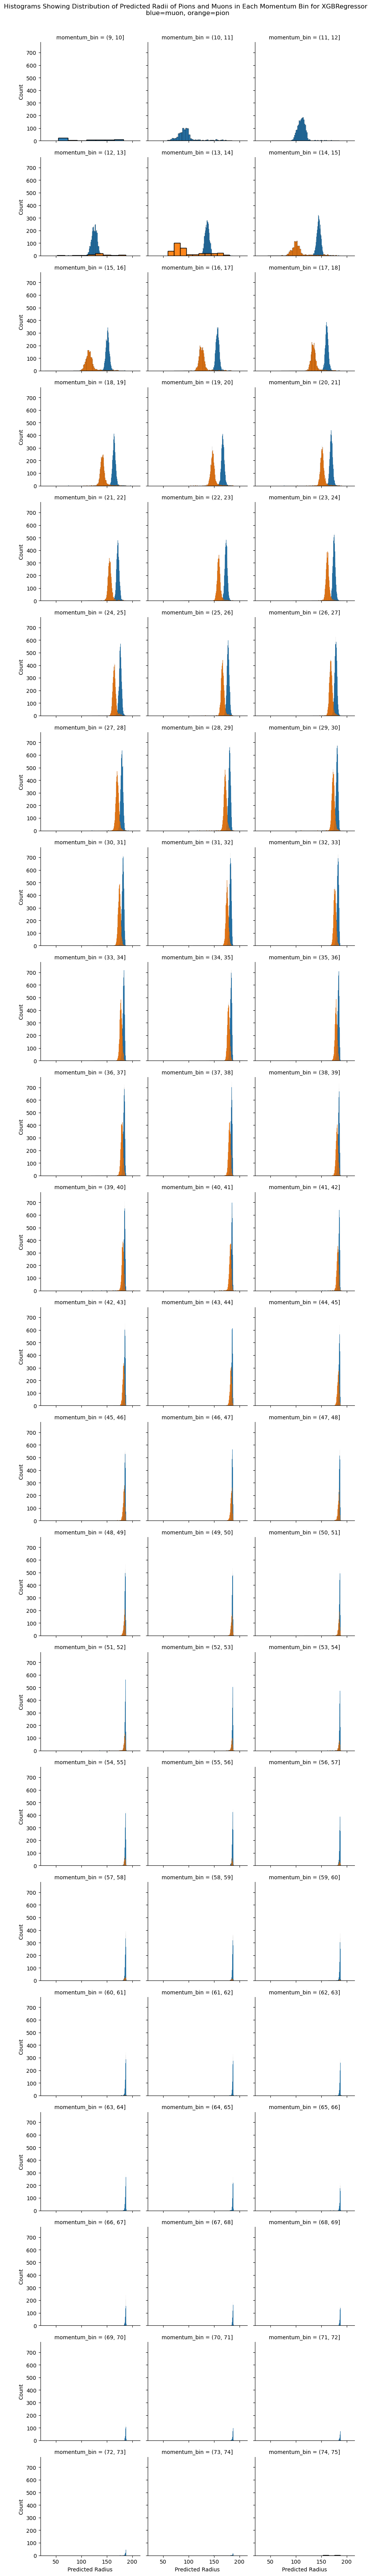

In [56]:
# Cut the momentum bins such that each bin size is 1 GeV/c
test_result = test_df.copy()
bins = np.arange(9, 76, 1)
test_result['momentum_bin'] = pd.cut(test_result['track_momentum'], bins=bins)

# Predict on the test set 
test_result['radius_pred'] = xgb_reg.predict(test_result.iloc[:, 1:19])

# Plot the distribution of predicted radius of pions and muons in each momentum bin
g = sns.FacetGrid(test_result, col='momentum_bin', col_wrap=3, hue='class')
g.map(sns.histplot, 'radius_pred', fill=True)
g.map(sns.histplot, 'radius_pred', lw=1)
g.set_axis_labels('Predicted Radius', 'Count')

plt.suptitle('Histograms Showing Distribution of Predicted Radii of Pions and Muons in Each Momentum Bin for XGBRegressor \n blue=muon, orange=pion', y=1.01)

plt.show()



## Plot the muons FPR vs. quantiles in each momentum bin for XGBRegressor and SOTA

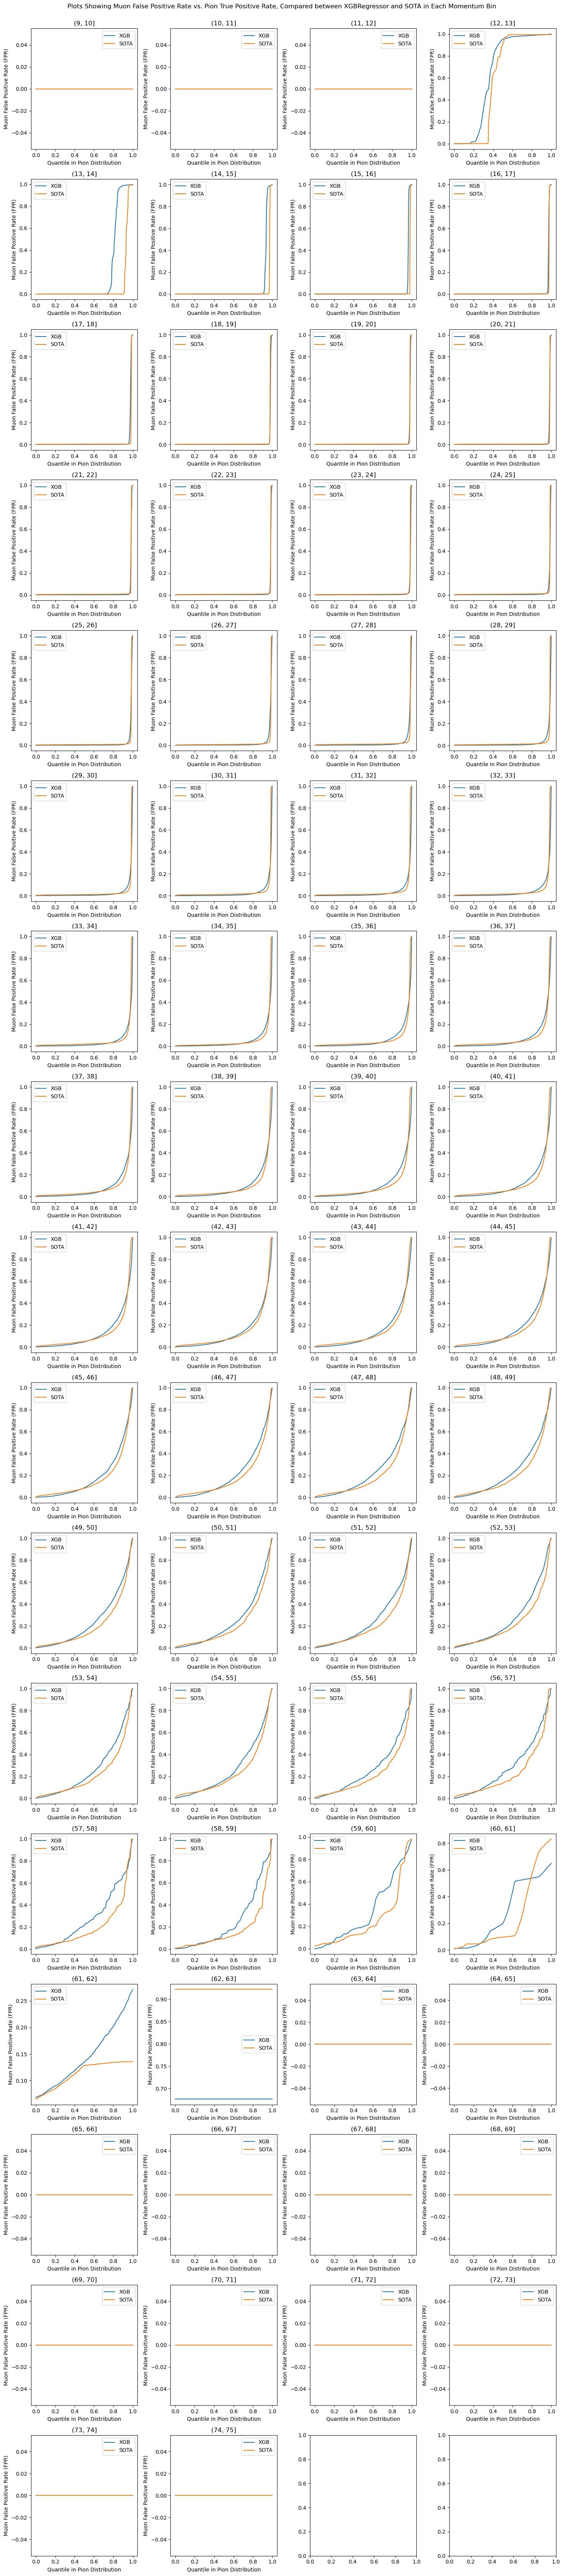

In [59]:
# Convert the momntum bins into list 
momentum_bins = test_result['momentum_bin'].sort_values().unique()

# Define number of rows and columns for the plots 
num_rows = (len(momentum_bins) + 3) // 4
num_cols = min(len(momentum_bins), 4)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))

axes = axes.flatten()

# Iterate over each momentum bin to plot the FPRs of muons given the TPRs of pions 
for i, momentum_bin in enumerate(momentum_bins):
    filtered_df = test_result[test_result['momentum_bin'] == momentum_bin]

    filtered_muons = filtered_df[filtered_df['class'] == 'muon']
    filtered_pions = filtered_df[filtered_df['class'] == 'pion']

    quantiles = np.linspace(0, 1, num=400)
    decision_boundaries = filtered_pions['radius_pred'].quantile(quantiles)
    decision_boundaries_sota = filtered_pions['ring_radius'].quantile(quantiles)

    fprs_pred = []
    for decision_boundary in decision_boundaries:
        filtered_below_boundary = filtered_muons[filtered_muons['radius_pred'] < decision_boundary]
        fpr_pred = filtered_below_boundary.shape[0] / filtered_muons.shape[0]
        fprs_pred.append(fpr_pred)

    fprs_ring = []
    for decision_boundary in decision_boundaries_sota:
        filtered_below_boundary = filtered_muons[filtered_muons['ring_radius'] < decision_boundary]
        fpr_ring = filtered_below_boundary.shape[0] / filtered_muons.shape[0]
        fprs_ring.append(fpr_ring)

    data_pred = pd.DataFrame({'Quantile': quantiles, 'Muon FPR (radius_pred)': fprs_pred})

    data_ring = pd.DataFrame({'Quantile': quantiles, 'Muon FPR (ring_radius)': fprs_ring})

    ax = axes[i]
    sns.lineplot(data=data_pred, x='Quantile', y='Muon FPR (radius_pred)', ax=ax, label='XGB')
    sns.lineplot(data=data_ring, x='Quantile', y='Muon FPR (ring_radius)', ax=ax, label='SOTA')
    ax.set_xlabel('Quantile in Pion Distribution')
    ax.set_ylabel('Muon False Positive Rate (FPR)')
    ax.set_title(f'{momentum_bin}')
    ax.legend()

plt.suptitle('Plots Showing Muon False Positive Rate vs. Pion True Positive Rate, Compared between XGBRegressor and SOTA in Each Momentum Bin', y=1)

# Adjust the subplot layout
plt.tight_layout()
